# Music Recommendation Using ALS and SGD

## 1. Introduction

Big data analytics is the use of advanced analytic techniques against very large, diverse data sets. Nowadays, big data brings a significant benefit to a large number of areas such as education, health care, and the government sector. Companies take advantage of big data to improve their operational efficiency and offer marketing insights. The use of big data allows businesses to observe various customer-related patterns and trends. 

The recommendation system that predicts user preference for a set of items based on past experience is one of the most common machine learning applications based on sufficient data and big data. The most famous one is probably Amazon’s recommendation engine, which provides users their personalized page on the Amazon app.

Big data is too large to process using traditional database and software techniques. Therefore, pyspark is used to  distribute and cache data in memory and helps them to optimize machine learning algorithms on big data. In this project, I use two collaborative filtering approaches, Alternating Least Square (ALS) and Stochastic Gradient Descent (SGD) to create music recommenders, which recommend artists to people based on their historical preference on artists.

In [1]:
from pyspark.sql.types import *
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.mllib.recommendation import *
from math import sqrt
from matplotlib import pyplot as plt
%matplotlib inline

## 2. Loading and Cleaning the Dataset

The music listening dataset contains profiles for around 150,000 real people from Audioscrobbler. There are three files in the data:
* user_artist_data.txt: 3 columns, "userid", "artistid", and "playcount" (indicating how many times each user played each artist)
* artist_data.txt: 2 columns, "artistid", and "artist_name"
* artist_alias.txt: 2 columns, "badid" (incorrectly spelled artists), and "goodid" (correct artist ids).

The Audioscrobbler dataset record merely the number of times users listen to music instead of the explicit rating. A dataset like that tends to cover more users and artists.

First of all, the music listening dataset is uploaded into Hadoop File System by the following steps:

rosywen@rosy-cluster-m:~$ wget https://storage.googleapis.com/aas-data-sets/profiledata_06-May-2005.tar.gz

rosywen@rosy-cluster-m:~$ tar --extract --file profiledata_06-May-2005.tar.gz

rosywen@rosy-cluster-m:~$ hadoop fs -put ~/profiledata_06-May-2005/ /


In [2]:
#user_artist_data.txt
folder = "hdfs:///profiledata_06-May-2005/"
user_artist_schema = StructType([
    StructField("userId", LongType(), True),    
    StructField("artistId", LongType(), True),
    StructField("playCount", FloatType(), True)
])
user_artist = spark.read.csv(folder+"user_artist_data.txt", sep = " ", header=False, schema = user_artist_schema)
user_artist.head(5) #pyspark.sql.dataframe.DataFrame

[Row(userId=1000002, artistId=1, playCount=55.0),
 Row(userId=1000002, artistId=1000006, playCount=33.0),
 Row(userId=1000002, artistId=1000007, playCount=8.0),
 Row(userId=1000002, artistId=1000009, playCount=144.0),
 Row(userId=1000002, artistId=1000010, playCount=314.0)]

In [3]:
#artist_alias.txt
artist_alias_schema = StructType([
    StructField("badId", LongType(), True),    
    StructField("goodId", LongType(), True)
])
artist_alias = spark.read.csv(folder+"artist_alias.txt", sep = "\t", header=False, schema = artist_alias_schema)
artist_alias.head(5)

[Row(badId=1092764, goodId=1000311),
 Row(badId=1095122, goodId=1000557),
 Row(badId=6708070, goodId=1007267),
 Row(badId=10088054, goodId=1042317),
 Row(badId=1195917, goodId=1042317)]

In [4]:
#artist_data.txt
artist_schema = StructType([
    StructField("artistId", LongType(), True),    
    StructField("artistName", StringType(), True)
])
artist_data = spark.read.csv(folder+"artist_data.txt", sep = "\t", header=False, schema = artist_schema)
artist_data.head(5)

[Row(artistId=1134999, artistName=u'06Crazy Life'),
 Row(artistId=6821360, artistName=u'Pang Nakarin'),
 Row(artistId=10113088, artistName=u'Terfel, Bartoli- Mozart: Don'),
 Row(artistId=10151459, artistName=u'The Flaming Sidebur'),
 Row(artistId=6826647, artistName=u'Bodenstandig 3000')]

The name of an artist might be misspelled or nonstandard. For example, "Collective Souls" and "Collective Soul" may appear as different artist IDs in "user_artist_data.txt" even though they are completely the same. "artist_alias.txt" file contains "badid" artist IDs and "goodid" artist IDs. In order to have canonical ID for the same artist, I create a dictionary, which maps the "wrong" artist ID to "right" artist ID. 

In [5]:
artist_dict = {}
for artist in artist_alias.rdd.collect():
    artist_dict[artist[0]] = artist[1]
user_artist = user_artist.rdd.map(lambda x: (x[0], artist_dict[x[1]] if x[1] in artist_dict else x[1], x[2]))

Before doing any further analysis, I split the data into training(95%) data, validation data(2.5%), and testing data(2.5%).

In [6]:
(training_data, validation_data, testing_data) = user_artist.randomSplit([0.95, 0.025, 0.025], seed = 1) 
training_data.cache()
validation_data.cache()
testing_data.cache()
print(str(training_data.count()) + " training data set")
print(str(validation_data.count()) + " validation data set")
print(str(testing_data.count()) + " testing data set")

23083000 training data set
606111 validation data set
607747 testing data set


## 3. Alternating Least Square(ALS)

ALS is a very popular algorithm for making recommendations. It is implemented in the pyspark package "mllib" and built for a larges-scale collaborative filtering problem. 

When dealing with matrix factorization problem, I found it is useful to compute the relative error of rating, which is "playCount" in this case. The relative error is computed by the error of the predictions divided by the Frobenius Norm of play count. 

In [9]:
 def evaluation_RMES(data, model):
    test_reorg = data.map(lambda x:((int(x[0]), int(x[1])), float(x[2]))) 
    pred_test = model.predictAll(data.map(lambda x:(x[0], x[1])))
    pred_test_reorg = pred_test.map(lambda x: ((x[0],x[1]), x[2])) 
    joined = test_reorg.join(pred_test_reorg)
    test_loss = sqrt(joined.map(lambda r: (r[1][0] - r[1][1])**2).sum())   
    frob_error_orig = sqrt(data.map(lambda r: r[2]**2).sum())
    rel_error = test_loss/frob_error_orig #the relative error
    return rel_error

To determinate the best model, the most important parameter to ALS model is the rank number. In general, a lower rank causes a higher error, and a high rank may lead to overfitting. Therefore, I fit a set of parameters into validation data to pick the most suitable latent factor which has the lowest RMSE value.

In [ ]:
ranks = range(1,11)
rmse_lst = []
for rank in ranks:
    model = ALS.train(training_data, rank=rank, iterations=5, lambda_=0.02)
    model_RMES = evaluation_RMES(validation_data, model)
    rmse_lst.append(model_RMES)
    print("rank: " + str(rank) + ", model error: " + str(model_RMES))    

rank: 1, model error: 4.29575475616
rank: 2, model error: 2.67415855383
rank: 3, model error: 1.51715151875
rank: 4, model error: 2.64813860612
rank: 5, model error: 2.22537893404
rank: 6, model error: 2.11535135927
rank: 7, model error: 1.75072214807
rank: 8, model error: 2.73658578046
rank: 9, model error: 2.1439587104
rank: 10, model error: 1.82052118554


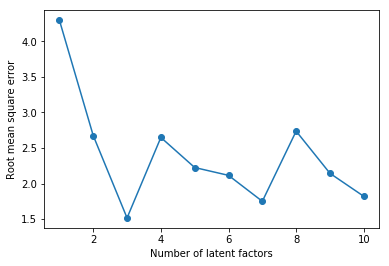

In [11]:
plt.plot(ranks,rmse_lst,'o-')  
plt.xlabel('Number of latent factors')
plt.ylabel('Root mean square error')
plt.show()

The smallest RMSE was obtained by the best ALS model with rank number 3, and it has test RMSE 1.6365 as shown below.

In [ ]:
#test RMSE
best_model = ALS.train(training_data, rank=3, iterations=5, lambda_=0.02)
test_RMES = evaluation_RMES(testing_data, best_model)
print('test RMSE: ' + str(test_RMES))    

test RMSE: 1.63652897379


At last, I use the best ALS model to recommend the top N artists for a user.

In [14]:
user_id = 1059637
num = 5
TopFive = best_model.recommendProducts(user_id ,num)
print("Top " + str(num) + " artist recommend to user " + str(user_id) + " are: ")
for i in range(5):
    artist = artist_data.rdd.filter(lambda x:x[0] == TopFive[i][1]).collect()[0][1]
    print(artist)

Top 5 artist recommend to user 1059637 are: 
Killswitch Engage - The End Of
Crime brothers
lizkar, crazy
Spain In My Heart (Various)
Alstroemeria Records


## 4. Stochastic Gradient Descent (SGD)
The stochastic gradient descent (SGD) approach are implemented in recommender_part2.ipynb.